In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
%cd ../..

/scratch/km817/iREC


In [4]:
import torch
import hamiltorch
import matplotlib.pyplot as plt
import pyro.distributions as dist
import torch.distributions as D
import torch.nn as nn
import torch.nn.functional as F

In [5]:
%matplotlib inline

In [6]:
hamiltorch.set_random_seed(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
hamiltorch.__version__

'0.4.0.dev1'

In [86]:
from models.BNNs.BNN_KDE_CLASSIFICATION import BNN_KDE

In [816]:
class Net(nn.Module):
    def __init__(self, num_nodes: int = 10):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(4, num_nodes)
        self.fc2 = nn.Linear(num_nodes, num_nodes)
        self.fc3 = nn.Linear(num_nodes, 3)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))

        x = torch.tanh(self.fc2(x))

        x = self.fc3(x)

        return x
num_nodes = 2
net = Net(num_nodes=num_nodes)
    

print(net)


Net(
  (fc1): Linear(in_features=4, out_features=2, bias=True)
  (fc2): Linear(in_features=2, out_features=2, bias=True)
  (fc3): Linear(in_features=2, out_features=3, bias=True)
)


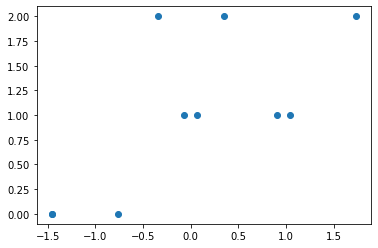

In [670]:
from sklearn.datasets import load_iris
import numpy as np
np.random.seed(0)
device = torch.device('cpu')
data = load_iris()
x_ = data['data']
y_ = data['target']
N_tr = 10
N_val = 150 - N_tr
a = np.arange(x_.shape[0])
train_index = np.random.choice(a, size = N_tr, replace = False)
val_index = np.delete(a, train_index, axis=0)
x_train = x_[train_index]
y_train = y_[train_index]
x_val = x_[val_index][:]
y_val = y_[val_index][:]
x_m = x_train.mean(0)
x_s = x_train.std(0)
x_train = (x_train-x_m)/ x_s
x_val = (x_val-x_m)/ x_s
D_in = x_train.shape[1]
x_train = torch.FloatTensor(x_train)
y_train = torch.FloatTensor(y_train)
x_val = torch.FloatTensor(x_val)
y_val = torch.FloatTensor(y_val)
plt.scatter(x_train.numpy()[:,0],y_train.numpy())
    
x_train = x_train.to(device)
y_train = y_train.to(device)
x_val = x_val.to(device)
y_val = y_val.to(device)

In [671]:
## Set hyperparameters for network
ELBO_BETA = 1.
alpha = 1./10.
tau_list = []
tau = alpha * ELBO_BETA
for w in net.parameters():
    tau_list.append(tau)
tau_list = torch.tensor(tau_list).to(device)

In [672]:
hamiltorch.set_random_seed(123)
params_init = hamiltorch.util.flatten(net).to(device).clone()

step_size = 0.15 
num_samples = 5000
burn = 1000
L = 10
tau_out = 1.
integrator = hamiltorch.Integrator.EXPLICIT
sampler = hamiltorch.Sampler.HMC_NUTS
params_hmc = hamiltorch.sample_model(net, x_train, y_train, params_init=params_init, num_samples=num_samples,
                               step_size=step_size, num_steps_per_sample=L,tau_out=tau_out,tau_list=tau_list,
                                    sampler=sampler, integrator=integrator, burn=burn)

Sampling (Sampler.HMC; Integrator.EXPLICIT)
Time spent  | Time remain.| Progress             | Samples   | Samples/sec
Final Adapted Step Size:  0.15771983563899994--- |  996/5000 | 54.63       
0d:00:01:27 | 0d:00:00:00 | #################### | 5000/5000 | 57.47       
Acceptance Rate 0.60


In [673]:
hmc_weights = torch.empty([0])
for w in params_hmc:
    hmc_weights = torch.cat([hmc_weights, w[None]])

In [674]:
pred_list, log_prob_list = hamiltorch.predict_model(net, x=x_val, y=y_val, samples=params_hmc[:], model_loss='multi_class_linear_output', tau_out=1., tau_list=tau_list)

In [675]:
%time pred_list, log_prob_list = hamiltorch.predict_model(net, x=x_val, y=y_val, samples=params_hmc[:], model_loss='multi_class_linear_output', tau_out=1., tau_list=tau_list)
_, pred = torch.max(pred_list, 2)
acc = torch.zeros( len(pred_list)-1)
nll = torch.zeros( len(pred_list)-1)
ensemble_proba = F.softmax(pred_list[0], dim=-1)
for s in range(1,len(pred_list)):
    _, pred = torch.max(pred_list[:s].mean(0), -1)
    acc[s-1] = (pred.float() == y_val.flatten()).sum().float()/y_val.shape[0]
    ensemble_proba += F.softmax(pred_list[s], dim=-1)
    nll[s-1] = F.nll_loss(torch.log(ensemble_proba.cpu()/(s+1)), y_val[:].long().cpu().flatten(), reduction='mean')

CPU times: user 2.57 s, sys: 0 ns, total: 2.57 s
Wall time: 2.57 s


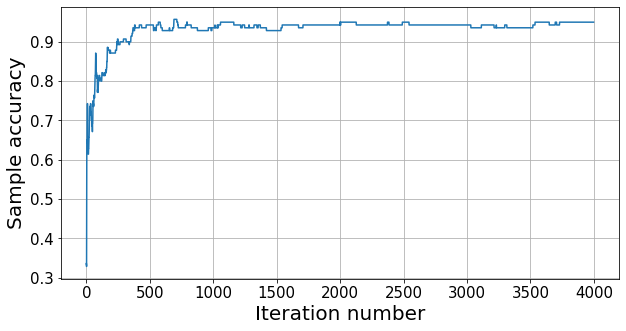

In [676]:
fs = 20
plt.figure(figsize=(10,5))
plt.plot(acc)
plt.grid()
plt.xlabel('Iteration number',fontsize=fs)
plt.ylabel('Sample accuracy',fontsize=fs)
plt.tick_params(labelsize=15)
plt.show()

# Draw subset of samples

In [754]:
g = torch.Generator()
g.manual_seed(0)
perm = torch.randperm(hmc_weights.size(0), generator=g)
num_s = 500
idx = perm[:num_s]
samples = hmc_weights[idx]
samples_rest = hmc_weights[perm[num_s:]]

In [678]:
def compute_categorical_mixture(preds, y):
    mix = D.Categorical(torch.ones(preds.shape[0]))
    comp = D.Categorical(logits=preds.permute(1, 0, 2))
    
    mixture_of_categorical = D.MixtureSameFamily(mix, comp)
    mean_preds = torch.argmax(mixture_of_categorical.component_distribution.probs.mean(1), dim=1).float()
    accuracy = torch.sum(mean_preds == y) / y.shape[0]
    
    ll = mixture_of_categorical.log_prob(y).mean()
    return accuracy, ll

In [817]:
pred_list, log_prob_list = hamiltorch.predict_model(net, x=x_val, y=y_val, samples=samples, 
                                                    model_loss='multi_class_linear_output', tau_out=1., 
                                                    tau_list=tau_list)

In [819]:
compute_categorical_mixture(pred_list, y_val)

(tensor(0.9500), tensor(-0.3758))

# Build a KDE

# KDE 100 Samples

In [823]:
# find optimal kde_var
from models.BNNs.BNN_KDE_CLASSIFICATION import BNN_KDE
from tqdm.notebook import trange

In [824]:
bnn_kde = BNN_KDE(alpha=1., emp_samples=hmc_weights, num_nodes=num_nodes, kl_beta=ELBO_BETA)

with torch.no_grad():
    rho_linspace = torch.linspace(-10, 2, 20)
    rho_elbos = torch.zeros_like(rho_linspace)
    for i, rho in enumerate(rho_linspace):
        bnn_kde.log_kde_rho = nn.Parameter(rho)
        rho_elbos[i] = bnn_kde.elbo(x_train, y_train, 32)

In [825]:
initial_rho = rho_linspace[torch.argmax(rho_elbos)].item()

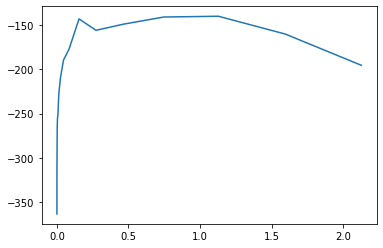

In [826]:
plt.plot(F.softplus(rho_linspace), rho_elbos.numpy())

In [827]:
bnn_kde.log_kde_rho = nn.Parameter(rho_linspace[torch.argmax(rho_elbos)])
KDE_target = bnn_kde.kde

In [828]:
from rec.utils import kl_estimate_with_mc
prior = D.MultivariateNormal(loc=torch.zeros_like(samples[0]), covariance_matrix = 1./alpha * torch.eye(samples.shape[-1]))
kl_q_p = kl_estimate_with_mc(KDE_target, prior)
print(f"{kl_q_p}")

20.612539291381836


In [829]:
num_compressed_samples = 1000
compressed_weights_kde_exact = KDE_target.sample((num_compressed_samples,))

pred_list_kde, _ = hamiltorch.predict_model(net, x=x_val, y=y_val, samples=compressed_weights_kde_exact, 
                                                    model_loss='multi_class_linear_output', tau_out=1., 
                                                    tau_list=tau_list)

In [830]:
compute_categorical_mixture(pred_list_kde, y_val)

(tensor(0.9500), tensor(-0.6013))

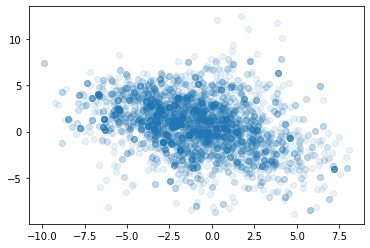

In [831]:
plt.scatter(hmc_weights[:, 0], hmc_weights[:, 1], alpha=0.1)

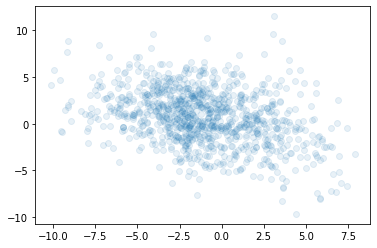

In [832]:
plt.scatter(compressed_weights_kde_exact[:, 0], compressed_weights_kde_exact[:, 1], alpha=0.1)

In [ ]:
bnn_kde = BNN_KDE(initial_rho=initial_rho,
                 alpha=1., emp_samples=hmc_weights, num_nodes=num_nodes, kl_beta=ELBO_BETA)

num_epochs = 100
num_parallel_samples = 32
optimiser = torch.optim.Adam(bnn_kde.parameters(), lr=1e-3)
stds = []
losses = []
for i in trange(num_epochs):
    optimiser.zero_grad()
    loss = -bnn_kde.elbo(x_train, y_train, num_parallel_samples)
    stds.append(F.softplus(bnn_kde.log_kde_rho.detach()).numpy())
    if i % 10 - 1 == 0:
        losses.append(loss.item())
        print(f'The loss is: {torch.tensor(losses[-10:]).mean():.5f}')
    loss.backward()
    optimiser.step()

  0%|          | 0/100 [00:00<?, ?it/s]

The loss is: 144.79346
The loss is: 149.45634
The loss is: 148.31241
The loss is: 146.80785
The loss is: 145.75493
The loss is: 145.14095
The loss is: 145.01820


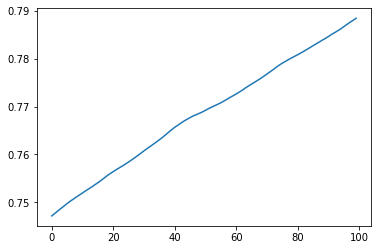

In [715]:
plt.plot(stds)

In [716]:
KDE_target = bnn_kde.kde

In [717]:
from rec.utils import kl_estimate_with_mc
prior = D.MultivariateNormal(loc=torch.zeros_like(samples[0]), covariance_matrix = 1./alpha * torch.eye(samples.shape[-1]))
kl_q_p = kl_estimate_with_mc(KDE_target, prior)
print(f"{kl_q_p}")

28.512100219726562


In [718]:
num_compressed_samples = 1000
compressed_weights_kde_exact = KDE_target.sample((num_compressed_samples,))

pred_list_kde, _ = hamiltorch.predict_model(net, x=x_val, y=y_val, samples=compressed_weights_kde_exact, 
                                                    model_loss='multi_class_linear_output', tau_out=1., 
                                                    tau_list=tau_list)

In [719]:
compute_categorical_mixture(pred_list_kde, y_val)

(tensor(0.9500), tensor(-0.5221))

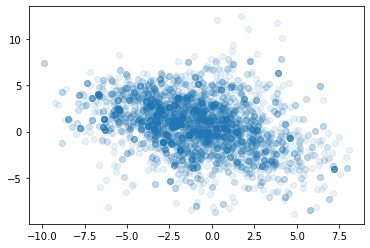

In [720]:
plt.scatter(hmc_weights[:, 0], hmc_weights[:, 1], alpha=0.1)

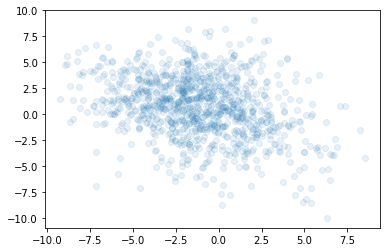

In [721]:
plt.scatter(compressed_weights_kde_exact[:, 0], compressed_weights_kde_exact[:, 1], alpha=0.1)

In [722]:
def compute_expected_coding_efficiency(kl, epsilon=0.2):
    K = (1 + epsilon) * kl
    return K + torch.log(K + 1) + 1

In [723]:
compute_expected_coding_efficiency(kl_q_p)

tensor(38.7760, grad_fn=<AddBackward0>)

# Lets optimise the variances

In [730]:
#lets compress some samples
#### sample weights with compression algorithm
from tqdm.notebook import trange
from rec.beamsearch.Coders.Encoder_Empirical import Encoder
from rec.beamsearch.distributions.CodingSampler import CodingSampler
from rec.beamsearch.distributions.EmpiricalMixturePosterior import EmpiricalMixturePosterior
from rec.beamsearch.samplers.GreedySampling_BNNs import GreedySampler
from models.BNNs.BNN_for_HMC_classification import BNN_for_HMC
import pyro.distributions as dist

In [731]:
dummy_model = BNN_for_HMC(alpha=alpha, num_nodes=num_nodes)

In [732]:
dummy_model.make_weights_from_sample(KDE_target.sample())

In [735]:
dummy_model.predict()

tensor(12)

In [726]:
# import pickle as pkl
# pkl.dump(emp_samples, open("PickledStuff/emp_samples.pkl", "wb"))
# pkl.dump(x_data, open("PickledStuff/x_data.pkl", "wb"))
# pkl.dump(y_data, open("PickledStuff/y_data.pkl", "wb"))
# pkl.dump(ys, open("PickledStuff/ys.pkl", "wb"))
# pkl.dump(xs, open("PickledStuff/xs.pkl", "wb"))

In [727]:
emp_dist = dist.Empirical(samples, log_weights=torch.ones(samples.shape[0]))

In [611]:
from rec.OptimisingVars.FinalJointOptimiser import FinalJointOptimiser
coding_sampler = CodingSampler
auxiliary_posterior = EmpiricalMixturePosterior
selection_sampler = GreedySampler
omega = 5
initial_seed = 0
beamwidth = 1
epsilon = 0.
dummy_encoder = Encoder(dummy_model,
                     x_train,
                     y_train,
                     samples,
                     initial_seed,
                     coding_sampler,
                     selection_sampler,
                     auxiliary_posterior,
                     omega,
                     beamwidth,
                     epsilon=epsilon,
                     prior_var=1./alpha,
                     total_kl=kl_q_p)

z_sample = emp_dist.mean
omega = 5
n_trajectories = 64
n_auxiliaries = dummy_encoder.n_auxiliary
prior_var = 1./alpha
emp_opt = FinalJointOptimiser(z_sample, omega, n_auxiliaries, kl_q_p, n_trajectories, prior_var)
aux_vars = emp_opt.run_optimiser(epochs=1000)

The mean loss is 2.48887. The mean KL is: 5.11043: 100%|██████████| 1000/1000 [01:48<00:00,  9.23it/s]


# Let's use the EMP scheme

In [616]:
coding_sampler = CodingSampler
auxiliary_posterior = EmpiricalMixturePosterior
selection_sampler = GreedySampler
omega = 5

initial_seed = 0
beamwidth = 1
epsilon = 0.
num_compressed_samples = 1
compressed_weights_emp_low_eps = []

for i in trange(num_compressed_samples):
    initial_seed = initial_seed + i * 10
    encoder = Encoder(dummy_model,
                     x_train,
                     y_train,
                     samples,
                     initial_seed,
                     coding_sampler,
                     selection_sampler,
                     auxiliary_posterior,
                     omega,
                     beamwidth,
                     epsilon=epsilon,
                     prior_var=1./alpha,
                     total_kl=kl_q_p)
    
    encoder.auxiliary_posterior.coding_sampler.auxiliary_vars = aux_vars
    
    w, idx = encoder.run_encoder()
    compressed_weights_emp_low_eps.append(w[0])

  0%|          | 0/1 [00:00<?, ?it/s]

In [634]:
dummy_model.make_weights_from_sample(KDE_target.sample())

In [635]:
torch.argmax(dummy_model.predict(x_train),dim=1)

tensor([2, 1, 0, 1, 0, 2, 0, 1, 1, 1])

In [627]:
y_train

tensor([2., 1., 0., 2., 0., 2., 0., 1., 1., 1.])

In [621]:
KDE_target.sample().shape

torch.Size([39])

  0%|          | 0/250 [00:00<?, ?it/s]

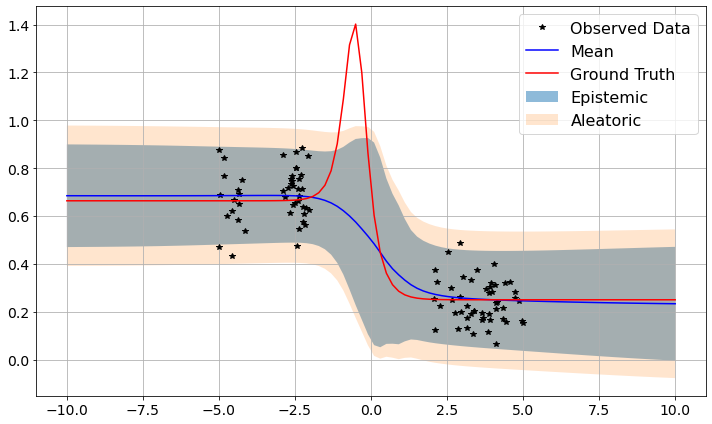

In [50]:
coding_sampler = CodingSampler
auxiliary_posterior = EmpiricalMixturePosterior
selection_sampler = GreedySampler
omega = 5

initial_seed = 0
beamwidth = 1
epsilon = 0.1
num_compressed_samples = 250
compressed_weights_emp_med_eps = []

for i in trange(num_compressed_samples):
    initial_seed = initial_seed + i * 10
    encoder = Encoder(dummy_model,
                     x_data,
                     y_data,
                     samples,
                     initial_seed,
                     coding_sampler,
                     selection_sampler,
                     auxiliary_posterior,
                     omega,
                     beamwidth,
                     epsilon=epsilon,
                     prior_var=1./alpha,
                     total_kl=kl_q_p)
    
    encoder.auxiliary_posterior.coding_sampler.auxiliary_vars = aux_vars
    
    w, idx = encoder.run_encoder()
    compressed_weights_emp_med_eps.append(w[0])

pred_list_emp_med_eps, log_probs_f = hamiltorch.predict_model(net, x = xs.to(device),
                                                  y = xs.to(device), samples=compressed_weights_emp_med_eps,
                                                  model_loss=model_loss, tau_out=tau_out,
                                                  tau_list=tau_list)

plot_preds(pred_list_emp_med_eps)

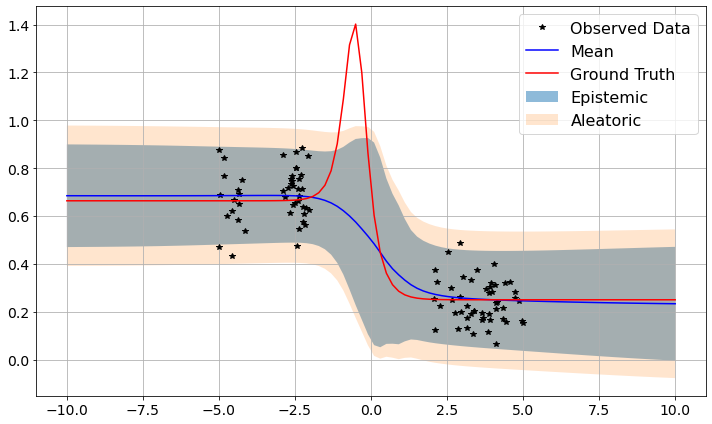

In [51]:
plot_preds(pred_list_emp_med_eps)

  0%|          | 0/250 [00:00<?, ?it/s]

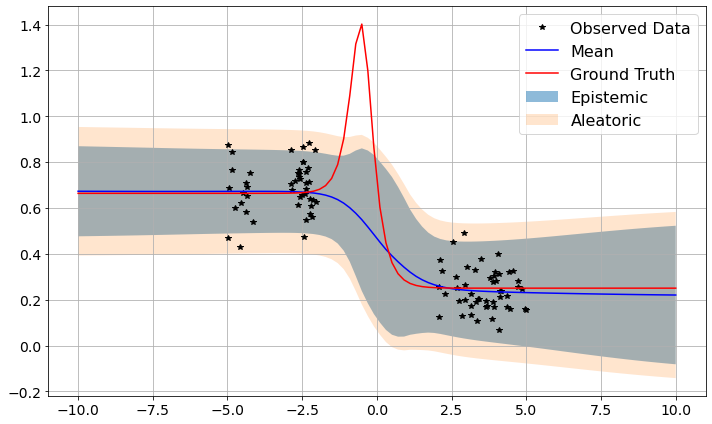

In [52]:
coding_sampler = CodingSampler
auxiliary_posterior = EmpiricalMixturePosterior
selection_sampler = GreedySampler
omega = 5

initial_seed = 0
beamwidth = 1
epsilon = 0.2
num_compressed_samples = 250
compressed_weights_emp_high_eps = []

for i in trange(num_compressed_samples):
    initial_seed = initial_seed + i * 10
    encoder = Encoder(dummy_model,
                     x_data,
                     y_data,
                     samples,
                     initial_seed,
                     coding_sampler,
                     selection_sampler,
                     auxiliary_posterior,
                     omega,
                     beamwidth,
                     epsilon=epsilon,
                     prior_var=1./alpha,
                     total_kl=kl_q_p)
    
    encoder.auxiliary_posterior.coding_sampler.auxiliary_vars = aux_vars
    
    w, idx = encoder.run_encoder()
    compressed_weights_emp_high_eps.append(w[0])

pred_list_emp_high_eps, log_probs_f = hamiltorch.predict_model(net, x = xs.to(device),
                                                  y = xs.to(device), samples=compressed_weights_emp_high_eps,
                                                  model_loss=model_loss, tau_out=tau_out,
                                                  tau_list=tau_list)

plot_preds(pred_list_emp_high_eps)

# Let's try the KDE coder

In [579]:
from rec.beamsearch.distributions.CodingSampler import CodingSampler
from rec.beamsearch.distributions.KDEPosterior import KDEPosterior
from rec.beamsearch.samplers.GreedySampling import GreedySampler
from rec.beamsearch.Coders.Encoder_KDE import EncoderKDE

In [580]:
num_compressed_samples = 500
compressed_weights_kde_exact = KDE_target.sample((num_compressed_samples,))

In [581]:
coding_sampler = CodingSampler
auxiliary_posterior = KDEPosterior
selection_sampler = GreedySampler
omega = 5

initial_seed = 0
beamwidth = 1
epsilon = 0.
num_compressed_samples = 250
compressed_weights_kde_low_eps = []

for i in trange(num_compressed_samples):
    initial_seed = initial_seed + i * 10
    encoder = EncoderKDE(KDE_target,
                        initial_seed,
                        coding_sampler,
                        selection_sampler,
                        auxiliary_posterior,
                        omega,
                        epsilon=epsilon,
                        beamwidth=beamwidth,
                        prior_var=1./alpha)
    
    encoder.auxiliary_posterior.coding_sampler.auxiliary_vars = aux_vars
    
    w, idx = encoder.run_encoder()
    compressed_weights_kde_low_eps.append(w[0])

  0%|          | 0/250 [00:00<?, ?it/s]

KeyboardInterrupt: 

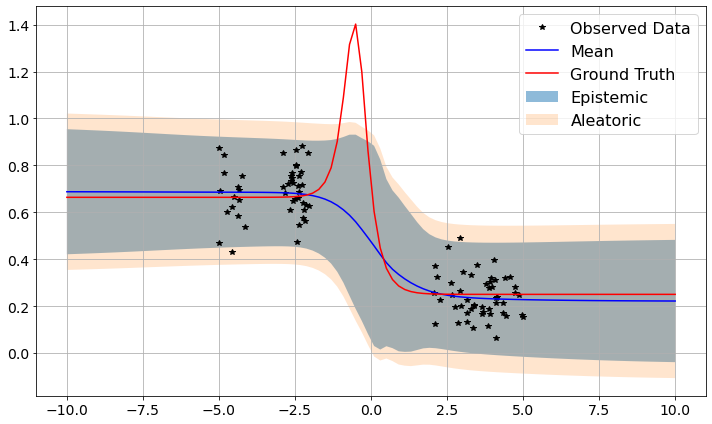

In [57]:
pred_list_kde_low_eps, log_probs_f = hamiltorch.predict_model(net, x = xs.to(device),
                                                  y = xs.to(device), samples=compressed_weights_kde_low_eps,
                                                  model_loss=model_loss, tau_out=tau_out,
                                                  tau_list=tau_list)

plot_preds(pred_list_kde_low_eps)


In [58]:
coding_sampler = CodingSampler
auxiliary_posterior = KDEPosterior
selection_sampler = GreedySampler
omega = 5

initial_seed = 0
beamwidth = 1
epsilon = 0.1
num_compressed_samples = 250
compressed_weights_kde_med_eps = []

for i in trange(num_compressed_samples):
    initial_seed = initial_seed + i * 10
    encoder = EncoderKDE(KDE_target,
                        initial_seed,
                        coding_sampler,
                        selection_sampler,
                        auxiliary_posterior,
                        omega,
                        epsilon=epsilon,
                        beamwidth=beamwidth,
                        prior_var=1./alpha)
    
    encoder.auxiliary_posterior.coding_sampler.auxiliary_vars = aux_vars
    
    w, idx = encoder.run_encoder()
    compressed_weights_kde_med_eps.append(w[0])

  0%|          | 0/250 [00:00<?, ?it/s]

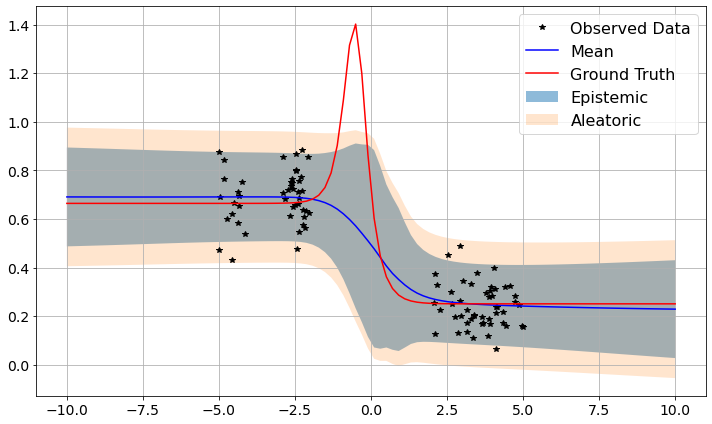

In [59]:
pred_list_kde_med_eps, log_probs_f = hamiltorch.predict_model(net, x = xs.to(device),
                                                  y = xs.to(device), samples=compressed_weights_kde_med_eps,
                                                  model_loss=model_loss, tau_out=tau_out,
                                                  tau_list=tau_list)

plot_preds(pred_list_kde_med_eps)


In [60]:
coding_sampler = CodingSampler
auxiliary_posterior = KDEPosterior
selection_sampler = GreedySampler
omega = 5

initial_seed = 0
beamwidth = 1
epsilon = 0.2
num_compressed_samples = 250
compressed_weights_kde_high_eps = []

for i in trange(num_compressed_samples):
    initial_seed = initial_seed + i * 10
    encoder = EncoderKDE(KDE_target,
                        initial_seed,
                        coding_sampler,
                        selection_sampler,
                        auxiliary_posterior,
                        omega,
                        epsilon=epsilon,
                        beamwidth=beamwidth,
                        prior_var=1./alpha)
    
    encoder.auxiliary_posterior.coding_sampler.auxiliary_vars = aux_vars
    
    w, idx = encoder.run_encoder()
    compressed_weights_kde_high_eps.append(w[0])

  0%|          | 0/250 [00:00<?, ?it/s]

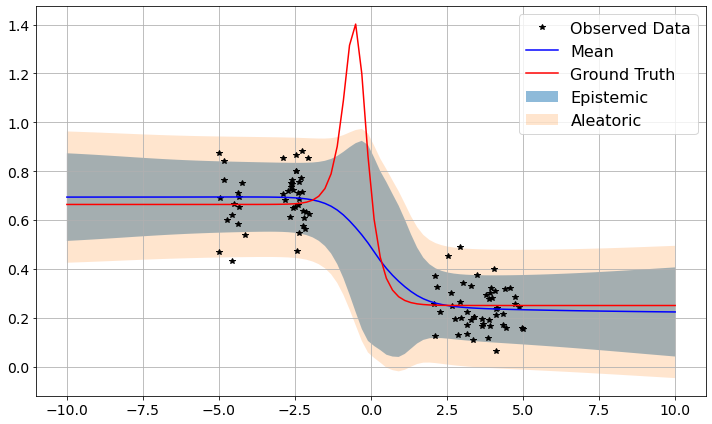

In [61]:
pred_list_kde_high_eps, log_probs_f = hamiltorch.predict_model(net, x = xs.to(device),
                                                  y = xs.to(device), samples=compressed_weights_kde_high_eps,
                                                  model_loss=model_loss, tau_out=tau_out,
                                                  tau_list=tau_list)

plot_preds(pred_list_kde_high_eps)


# Let's Compute some Statistics

In [62]:
def make_empirical_predictive(weights, x_input, y_output):
    pred_list, _ = hamiltorch.predict_model(net, x = x_input.flatten().to(device),
                                                  y = y_output.flatten().to(device), samples=weights,
                                                  model_loss='regression', tau_out=tau_out,
                                                  tau_list=tau_list)
    
    # need to make gmm at each sample
    return pred_list

def make_empirical_gmm(preds):
    mix = D.Categorical(torch.ones(preds.shape[0]))
    comp = D.Normal(loc=preds.squeeze().permute(1, 0), scale=beta ** -0.5)
    gmm = D.MixtureSameFamily(mix, comp)
    return gmm

def compute_gmm_lp(weights, x, y):
    preds = make_empirical_predictive(weights, x, y)
    
    gmm = make_empirical_gmm(preds)
    
    return gmm.log_prob(y.squeeze()).sum()

In [63]:
compute_gmm_lp(params_hmc_gpu, x_test, y_test)

tensor(157.3071)

In [64]:
compute_gmm_lp(params_hmc_gpu, x_data, y_data)

tensor(86.8398)

In [65]:
compute_gmm_lp(compressed_weights_emp_low_eps, x_test, y_test)

tensor(117.9036)

In [66]:
compute_gmm_lp(compressed_weights_emp_med_eps, x_test, y_test)

tensor(131.7273)

In [67]:
compute_gmm_lp(compressed_weights_emp_high_eps, x_test, y_test)

tensor(129.7028)

In [68]:
compute_gmm_lp(compressed_weights_kde_exact, x_test, y_test)

tensor(151.8553)

In [69]:
compute_gmm_lp(compressed_weights_kde_low_eps, x_test, y_test)

tensor(123.0284)

In [70]:
compute_gmm_lp(compressed_weights_kde_med_eps, x_test, y_test)

tensor(134.5398)

In [71]:
compute_gmm_lp(compressed_weights_kde_high_eps, x_test, y_test)

tensor(139.3759)

In [73]:
# dump the important stuff
import pickle as pkl
pkl.dump(kl_q_p, open(f'PickledStuff/BNN_BETA_CLASSIFICATION/EMP/hmc_kl_beta_{ELBO_BETA}.pkl', 'wb'))
pkl.dump(samples, open(f'PickledStuff/BNN_BETA_CLASSIFICATION/EMP/HMC_beta_{ELBO_BETA}.pkl', 'wb'))
pkl.dump(KDE_target, open(f'PickledStuff/BNN_BETA_CLASSIFICATION/EMP/HMC_KDE_target_beta_{ELBO_BETA}.pkl', 'wb'))
pkl.dump(compressed_weights_emp_low_eps, open(f'PickledStuff/BNN_BETA_RESULTS/EMP/emp_beta_{ELBO_BETA}_eps_0.pkl', 'wb'))
pkl.dump(compressed_weights_emp_med_eps, open(f'PickledStuff/BNN_BETA_RESULTS/EMP/emp_beta_{ELBO_BETA}_eps_0.1.pkl', 'wb'))
pkl.dump(compressed_weights_emp_high_eps, open(f'PickledStuff/BNN_BETA_RESULTS/EMP/emp_beta_{ELBO_BETA}_eps_0.2.pkl', 'wb'))
pkl.dump(compressed_weights_kde_exact, open(f'PickledStuff/BNN_BETA_RESULTS/KDE/kde_exact_beta_{ELBO_BETA}.pkl', 'wb'))
pkl.dump(compressed_weights_kde_low_eps, open(f'PickledStuff/BNN_BETA_RESULTS/KDE/kde_beta_{ELBO_BETA}_eps_0.pkl', 'wb'))
pkl.dump(compressed_weights_kde_med_eps, open(f'PickledStuff/BNN_BETA_RESULTS/KDE/kde_beta_{ELBO_BETA}_eps_0.1.pkl', 'wb'))
pkl.dump(compressed_weights_kde_high_eps, open(f'PickledStuff/BNN_BETA_RESULTS/KDE/kde_beta_{ELBO_BETA}_eps_0.2.pkl', 'wb'))

In [74]:
ELBO_BETA

2